# Beauty Classifier


In [3]:
# !pip install wget

  Running setup.py bdist_wheel for wget ... done
  Stored in directory: /home/ubuntu/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Setup and Helpers

In [4]:
# Imports
%run ../src/utils/helpers.py

from collections import defaultdict
import requests
import boto3
import tempfile
import wget

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from IPython.display import Image, display, clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
# Initialization
s3_client = boto3.client('s3')
s3 = boto3.resource('s3')
s3_resource = boto3.resource('s3')
bucket_name = 'eye-of-the-needle'
bucket = s3.Bucket(bucket_name)

In [6]:
# Download pre-trained weights
# print('Beginning file download of pre-trained weights')
# url = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'  
# filepath = '../models/vgg16_weights.h5'
# wget.download(url, filepath)  

Beginning file download of pre-trained weights


'../models/vgg16_weights.h5'

Records loaded. 500 out of 2392 photos have been labeled stunning.

Displaying images scored 1:
['2018/10/18/2018_1018_170000/thumbnail.jpg']


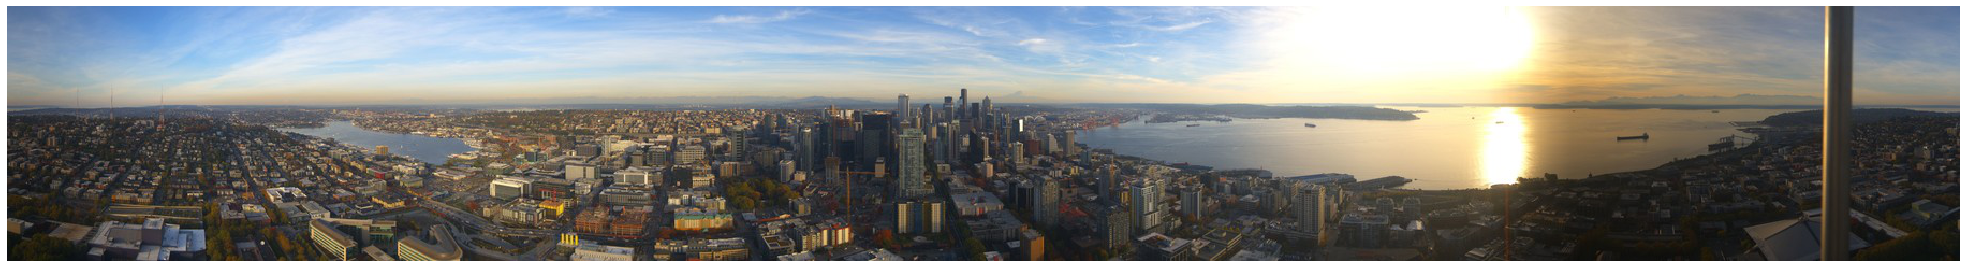

In [11]:
# Helper functions
record_path = '../data/raw/record.pkl'

@load_or_make(record_path, overwrite='n')
def get_record():
    record = defaultdict(dict)
    return record


def display_images(n, score=1):
    record = get_record()
    scores = sum(v['score'] for k, v in record.items())
    print(f"Records loaded. {scores} out of {len(record.keys())} photos have been labeled stunning.")
    l = list(record.keys())

    n_files = []
    while len(n_files) < n:
        f = random.choice(l)
        if record[f]['score'] == score:
            n_files.append(f)

    print(f"\nDisplaying images scored {score}:")
    print(n_files)
    fig = plt.figure(figsize=(35, 12))
    for i, file in enumerate(n_files):
        obj = bucket.Object(file)
        tmp = tempfile.NamedTemporaryFile()
        with open(tmp.name, 'wb') as f:
            obj.download_fileobj(f)
            img=mpimg.imread(tmp.name)
        ax = fig.add_subplot(n, 1, i + 1) 
        ax.imshow(img)
        ax.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    # plt.show()
    return img
n = 1
img = display_images(n, 1)

In [12]:
img.shape

(237, 1820, 3)

# Prep Data

In [58]:
import boto3
import os

from sklearn.model_selection import train_test_split


s3_client = boto3.client('s3')
s3_resource = boto3.resource('s3')

def download_from_s3(prefix, local_path, bucket=bucket_name, client=s3_client, resource=s3_resource):
    keys = []
    dirs = []
    next_token = ''
    base_kwargs = {
        'Bucket': bucket_name,
        'Prefix': prefix,
    }
    while next_token is not None:
        kwargs = base_kwargs.copy()
        if next_token != '':
            kwargs.update({'ContinuationToken': next_token})
        results = s3_client.list_objects_v2(**kwargs)
        contents = results.get('Contents')
        for i in contents:
            k = i.get('Key')
            if k[-1] != '/':
                keys.append(k)
            else:
                dirs.append(k)
        next_token = results.get('NextContinuationToken')
    for d in dirs:
        dest_pathname = os.path.join(local, d)
        if not os.path.exists(os.path.dirname(dest_pathname)):
            os.makedirs(os.path.dirname(dest_pathname))
    for k in keys:
        if not os.path.exists(os.path.dirname(local_path)):
            os.makedirs(os.path.dirname(local_path))
        resource.meta.client.download_file(bucket, k, local_path)
    return


def get_files(df, path):
    local_files = set(os.listdir("../data/imgs/"))
    target_files = set(data['filename'])
    missing = target_files.difference(local_files)
    needed = data[data['filename'].isin(missing)]
    print(f'Getting {len(missing)} files from S3...')
    needed.apply(lambda x: download_from_s3(x['filepath'], path + x['filename']), axis=1)
    print('Success!\n')
    pass


def get_df_from_record():
    record = get_record()
    df = pd.DataFrame.from_dict(record, orient='index').reset_index().sort_values(by='index')
    save_to(df, '../data/raw/df.pkl')
    return df


def process_df(df):
    parse = lambda x: ''.join(x.split('/')[3].split('_'))[:-2]
    date_strings = df['index'].apply(parse)
    filenames = date_strings + 'thumb.jpg'
    df['filename'] = filenames

    df['date'] = pd.to_datetime(date_strings, format='%Y%m%d%H%M', errors='ignore')
    df = df.set_index(pd.DatetimeIndex(df['date'])).drop('date', axis=1)
    df = df.rename(columns={'index': 'filepath'})
    save_to(df, '../data/interim/data.pkl')
    return df


def run():
    path = '../data/imgs/'
    df = get_df_from_record()
    data = process_df(df)
    
    train, test = train_test_split(data, test_size=0.2, random_state=42)
    train, val = train_test_split(train, test_size=0.2, random_state=42)
    
    save_to(train, '../data/interim/train.pkl')
    save_to(val, '../data/interim/val.pkl')
    save_to(test, '../data/interim/test.pkl')
    
    proportion = lambda x: x['score'].sum() / x.shape[0]
    msg = lambda x: f'{x.shape[0]} images with {round(100 * proportion(x), 2)}% positive class.'
    print(f'\nTrain set has {msg(train)}')
    print(f'Val set has {msg(val)}')
    print(f'Test set has {msg(test)}\n')
    
    get_files(data, path)
    
    return data

In [59]:
data = run()

Saved file to ../data/raw/df.pkl
Saved file to ../data/interim/data.pkl
Saved file to ../data/interim/train.pkl
Saved file to ../data/interim/val.pkl
Saved file to ../data/interim/test.pkl

Train set has 1530 images with 21.11% positive class.
Val set has 383 images with 21.41% positive class.
Test set has 479 images with 19.83% positive class.

Getting 0 files from S3...
Success!



In [116]:
from sklearn.model_selection import KFold
    
kf = KFold(n_splits=5, random_state=True) # Define the split - into 2 folds 
splits = kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator


## Extract features from convolutional base

We want to use a solution based on pre-trained models. We will use models that are composed of two parts:

* Convolutional base.
* Classifier.

Our approach will use the convolutional base to extract features, using them to train a classifier to classify the input image as beautiful or not. Therefore, the features extracted from the convolutional base will be the same for all classifiers studied in this example.

Now let's see how to extract features from a convolutional base.

In [62]:
# Extract features
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32
img_height, img_width = (237, 1820)

def extract_features(data, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_dataframe(dataframe=data, 
                                            directory='../data/imgs/', 
                                            x_col='filename', 
                                            y_col='score', 
                                            target_size=(img_height, img_width),
                                            class_mode='binary', 
                                            batch_size=batch_size,
                                            save_to_dir='../data/interim/'
                                           )

#     generator = datagen.flow_from_directory(directory,
#                                             target_size=(img_width, img_height),
#                                             batch_size = batch_size,
#                                             class_mode='binary')
    

    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [61]:
train = load_from('../data/interim/train.pkl')
val = load_from('../data/interim/val.pkl')
test = load_from('../data/interim/test.pkl')

proportion = lambda x: x['score'].sum() / x.shape[0]
msg = lambda x: f'{x.shape[0]} images with {round(100 * proportion(x), 2)}% positive class.'
print(f'\nTrain set has {msg(train)}')
print(f'Val set has {msg(val)}')
print(f'Test set has {msg(test)}\n')

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 1530 images with 21.11% positive class.
Val set has 383 images with 21.41% positive class.
Test set has 479 images with 19.83% positive class.



In [63]:
train_size = train.shape[0]
val_size = val.shape[0]
test_size = test.shape[0]

train_features, train_labels = extract_features(train, train_size)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(val, val_size)
test_features, test_labels = extract_features(test, test_size)


MemoryError: 

# Classifier

In [27]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.imagenet_utils import decode_predictions

Using TensorFlow backend.


In [13]:

# note we exclude the final dense layers and add one back below, we would retrain it ourselves
base_model = Xception(weights='imagenet', include_top=False, input_shape=(237, 1820, 3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
predictions = Dense(2, activation='softmax')(x) # should match # of classes predicted

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

## Non-recommended method

In [25]:
import os
import wget

In [ ]:
weight_file = '../models/vgg16_weights.h5'

if not os.path.exists(weight_file):
    # Download pre-trained weights
    print('Beginning file download of pre-trained weights')
    url = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'  
    filepath = '../models/vgg16_weights.h5'
    wget.download(url, filepath)  
#     raise FileNotFoundError("No file {weight_file} found. Check path again".format(weight_file))
